In [2]:
import os
from pathlib import Path

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets

from tqdm import tqdm

import time

from PIL import Image
import matplotlib.pyplot as plt

#used for finding most emoji-like final generated image
import torch.nn.functional as F_nn

colab = os.getenv('COLAB_GPU') != None

if colab:
    #used for making folders from Google Drive accessible
    from google.colab import drive

Ran for GPU compatability for running the model on local system:


---


**(Don't run these commands for running on Google Colab)**

> pip uninstall torch torchvision torchaudio

> pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [3]:
#doesn't need to run on Google Colab, just checks if running the model locally that it will use your GPU


#makes sure GPU will be used for processing
if not colab:
    print("CUDA version for PyTorch", torch.version.cuda)
    print(torch.cuda.get_device_name(0))
    processing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.set_default_device(processing_device)
    print(f"Model will use: {torch.get_default_device()}")


CUDA version for PyTorch 11.8
NVIDIA GeForce RTX 3060 Laptop GPU
Model will use: cuda:0


In [4]:
#directory path from Colab Notebooks folder in Google Drive
folder = "images_faces_only"

image_folder_path = folder
if colab:
    drive.mount("/content/drive")
    image_folder_path = f"/content/drive/My Drive/Colab Notebooks/{folder}"

print(f"\nVerifying that the images can be found in the directory and used in the model in the folder \"{folder}\":")
print(os.listdir(image_folder_path))



Verifying that the images can be found in the directory and used in the model in the folder "images_faces_only":
['JoyPixels', 'DoCoMo', 'Samsung', 'KDDI', 'Twitter', 'Apple', 'Windows', 'Facebook', 'Google', 'Gmail', 'SoftBank']


In [5]:
image_dimentions = 64

def load_and_preprocess_images(data_dir, target_size=(64, 64)):
    #got rid of dataset extra augmentation to reduce rotated corners in outputted images
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])

    images = []
    labels = []
    class_to_idx = {}

    for idx, class_name in enumerate(sorted(os.listdir(data_dir))):
        class_path = os.path.join(data_dir, class_name)
        
        # Only train on certain classes
        if class_name not in ['Apple', 'Google', 'Facebook', 'Samsung', 'Twitter', 'Windows', 'JoyPixels']:
            continue
        
        class_to_idx[class_name] = idx
        for file_name in tqdm(os.listdir(class_path)):
            file_path = os.path.join(class_path, file_name)
            if os.path.isdir(file_path):
                continue
            image = Image.open(file_path).convert("RGB")
            image = transform(image)
            images.append(image)
            labels.append(idx)

    images = torch.stack(images)
    labels = torch.tensor(labels)

    #if running on cuda:
    #images = torch.stack(images).to(processing_device)
    #labels = torch.tensor(labels).to(processing_device)

    return images, labels, class_to_idx

#loading the data
data_dir = image_folder_path #directory path from Colab Notebooks folder in Google Drive
target_size = (image_dimentions, image_dimentions)
images, labels, class_to_idx = load_and_preprocess_images(data_dir, target_size)

/home/sockyman/src/venv/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|███████████████████████████████████████████████████████████| 322/322 [00:00<00:00, 2186.65it/s]


In [6]:
class GeneratorNet(nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0),  #layer takes in (100, 1, 1), and outputs (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  #layer outputs (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  #layer outputs (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   #layer outputs (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),     #returns an image of dimensions (3, 64, 64)
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 100, 1, 1)  #reshape noise to input layer dimensions for the batch_size with (100, 1, 1)
        return self.model(x)

generator = GeneratorNet()

#if running on cuda:
#generator = GeneratorNet().to(processing_device)

In [7]:
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),      #layer takes in image (3, 64, 64), and outputs (64, 32, 32)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),    #layer outputs (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),   #layer outputs (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),   #layer outputs (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, 1, 0),     #layer outputs (1, 1, 1)
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

discriminator = DiscriminatorNet()

#if running locally use instead:
#discriminator = DiscriminatorNet().to(processing_device)

In [8]:
import torchinfo
print(torchinfo.summary(generator, input_size=(128, 100, 1, 1)))
print(torchinfo.summary(discriminator, input_size=(128, 3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
GeneratorNet                             [128, 3, 64, 64]          --
├─Sequential: 1-1                        [128, 3, 64, 64]          --
│    └─ConvTranspose2d: 2-1              [128, 512, 4, 4]          819,712
│    └─BatchNorm2d: 2-2                  [128, 512, 4, 4]          1,024
│    └─ReLU: 2-3                         [128, 512, 4, 4]          --
│    └─ConvTranspose2d: 2-4              [128, 256, 8, 8]          2,097,408
│    └─BatchNorm2d: 2-5                  [128, 256, 8, 8]          512
│    └─ReLU: 2-6                         [128, 256, 8, 8]          --
│    └─ConvTranspose2d: 2-7              [128, 128, 16, 16]        524,416
│    └─BatchNorm2d: 2-8                  [128, 128, 16, 16]        256
│    └─ReLU: 2-9                         [128, 128, 16, 16]        --
│    └─ConvTranspose2d: 2-10             [128, 64, 32, 32]         131,136
│    └─BatchNorm2d: 2-11                 [128, 64, 32, 32]

In [9]:
#if on cuda add param to all return statements: (..., device=processing_device)

def real_targets(size):
    return torch.full((size, 1), 0.9) #added label smoothing (floating points)

def fake_targets(size):
    return torch.full((size, 1), 0.1) #added label smoothing (floating points)

def noise(size):
    return torch.randn(size, 100)  #assume noise vector has 100 features

In [10]:
def image_grid(width, height, show_image=True, save_path=None, input_noise=None, size=8):
    if input_noise == None:
        input_noise = noise(width * height)
    generated_images = generator(input_noise).detach()
    grid = torchvision.utils.make_grid(generated_images, nrow=width, normalize=True)
    plt.figure(figsize=(size, size))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")

    if save_path != None:
        path = Path(save_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(path)
    
    if show_image:
        plt.show()

In [11]:
model_directory_root = 'models'
model_subdirectory = 'model'
model_directory = model_directory_root + '/' + model_subdirectory + '/'

def load_model():
    generator.load_state_dict(torch.load(model_directory + 'generator.pt', weights_only=True))
    discriminator.load_state_dict(torch.load(model_directory + 'discriminator.pt', weights_only=True))

def save_model():
    path = Path(model_directory)
    path.mkdir(parents=True, exist_ok=True)
    torch.save(generator.state_dict(), model_directory + 'generator.pt')
    torch.save(discriminator.state_dict(), model_directory + 'discriminator.pt')

In [12]:
# Only run this cell if you want to load saved model weights

try:
    load_model()
    print('model loaded')
except:
    print('model failed to load')

model loaded


In [13]:
# Noise to use when generating samples. Set to None to use different noise each epoch.
sample_noise = noise(9)


Epoch #0 / 2000, Generator Loss: 1.958646535873413, Discriminator Loss: 0.6505009531974792
Generated images for Epoch #0:


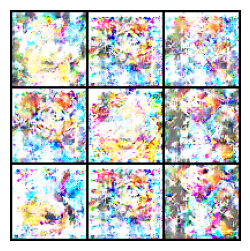

0:02
Epoch #1 / 2000, Generator Loss: 2.0493671894073486, Discriminator Loss: 0.6505070328712463
Epoch #2 / 2000, Generator Loss: 1.9585864543914795, Discriminator Loss: 0.6508250832557678
Epoch #3 / 2000, Generator Loss: 1.9932496547698975, Discriminator Loss: 0.6504502296447754
Epoch #4 / 2000, Generator Loss: 2.0182180404663086, Discriminator Loss: 0.6503896713256836
Generated images for Epoch #4:


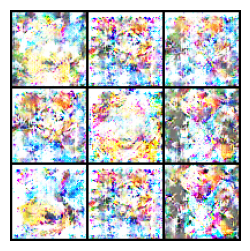

0:13
Epoch #5 / 2000, Generator Loss: 1.9868450164794922, Discriminator Loss: 0.6506686210632324
Epoch #6 / 2000, Generator Loss: 1.9927077293395996, Discriminator Loss: 0.6517626047134399
Epoch #7 / 2000, Generator Loss: 2.0224180221557617, Discriminator Loss: 0.6504427790641785
Epoch #8 / 2000, Generator Loss: 2.0348236560821533, Discriminator Loss: 0.6502794027328491
Generated images for Epoch #8:


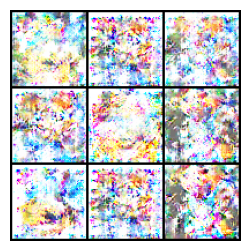

0:23
Epoch #9 / 2000, Generator Loss: 1.9958767890930176, Discriminator Loss: 0.6504167318344116
Epoch #10 / 2000, Generator Loss: 2.0240941047668457, Discriminator Loss: 0.6506270170211792
Epoch #11 / 2000, Generator Loss: 2.0010757446289062, Discriminator Loss: 0.6504275798797607
Epoch #12 / 2000, Generator Loss: 1.9743095636367798, Discriminator Loss: 0.6505351662635803
Generated images for Epoch #12:


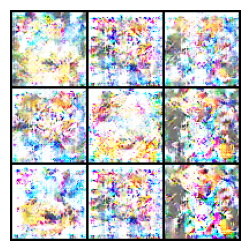

0:34
Epoch #13 / 2000, Generator Loss: 2.0181164741516113, Discriminator Loss: 0.6502529382705688
Epoch #14 / 2000, Generator Loss: 1.980433702468872, Discriminator Loss: 0.6503283381462097
Epoch #15 / 2000, Generator Loss: 2.007812738418579, Discriminator Loss: 0.6505730152130127
Epoch #16 / 2000, Generator Loss: 1.9892444610595703, Discriminator Loss: 0.6504784822463989
Generated images for Epoch #16:


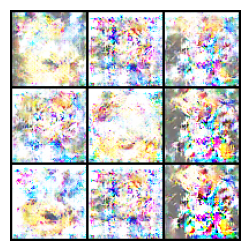

0:44
Epoch #17 / 2000, Generator Loss: 1.9564907550811768, Discriminator Loss: 0.6503946781158447
Epoch #18 / 2000, Generator Loss: 2.0232248306274414, Discriminator Loss: 0.6504893898963928
Epoch #19 / 2000, Generator Loss: 1.9733632802963257, Discriminator Loss: 0.6504201889038086
Epoch #20 / 2000, Generator Loss: 1.9709621667861938, Discriminator Loss: 0.6503911018371582
Generated images for Epoch #20:


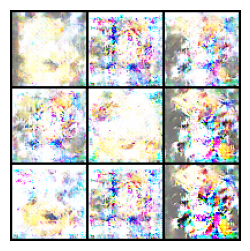

0:55
Epoch #21 / 2000, Generator Loss: 1.9990712404251099, Discriminator Loss: 0.6508042812347412
Epoch #22 / 2000, Generator Loss: 1.9776997566223145, Discriminator Loss: 0.6504230499267578
Epoch #23 / 2000, Generator Loss: 1.9680109024047852, Discriminator Loss: 0.6506339311599731
Epoch #24 / 2000, Generator Loss: 1.9961755275726318, Discriminator Loss: 0.650417149066925
Generated images for Epoch #24:


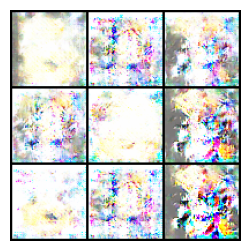

1:05
Epoch #25 / 2000, Generator Loss: 1.9560039043426514, Discriminator Loss: 0.650326132774353
Epoch #26 / 2000, Generator Loss: 1.8525680303573608, Discriminator Loss: 0.6509613990783691
Epoch #27 / 2000, Generator Loss: 1.9453401565551758, Discriminator Loss: 0.6509122252464294
Epoch #28 / 2000, Generator Loss: 1.9626014232635498, Discriminator Loss: 0.650382936000824
Generated images for Epoch #28:


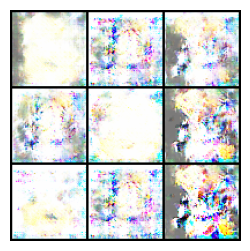

1:16
Epoch #29 / 2000, Generator Loss: 1.9595991373062134, Discriminator Loss: 0.6502823829650879
Epoch #30 / 2000, Generator Loss: 1.8115756511688232, Discriminator Loss: 0.6502546072006226
Epoch #31 / 2000, Generator Loss: 1.4980967044830322, Discriminator Loss: 0.6502926349639893
Epoch #32 / 2000, Generator Loss: 1.7231262922286987, Discriminator Loss: 0.6508028507232666
Generated images for Epoch #32:


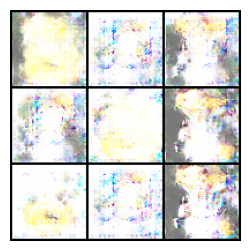

1:26
Epoch #33 / 2000, Generator Loss: 1.7740452289581299, Discriminator Loss: 0.6507622003555298
Epoch #34 / 2000, Generator Loss: 1.760998249053955, Discriminator Loss: 0.6504431962966919
Epoch #35 / 2000, Generator Loss: 1.8583462238311768, Discriminator Loss: 0.6507132053375244
Epoch #36 / 2000, Generator Loss: 1.098229169845581, Discriminator Loss: 0.6505507230758667
Generated images for Epoch #36:


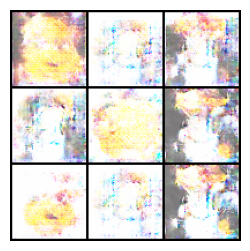

1:37
Epoch #37 / 2000, Generator Loss: 1.7373356819152832, Discriminator Loss: 0.65083909034729
Epoch #38 / 2000, Generator Loss: 1.7870268821716309, Discriminator Loss: 0.650596022605896
Epoch #39 / 2000, Generator Loss: 1.5051246881484985, Discriminator Loss: 0.6506437063217163
Epoch #40 / 2000, Generator Loss: 1.7884657382965088, Discriminator Loss: 0.6508534550666809
Generated images for Epoch #40:


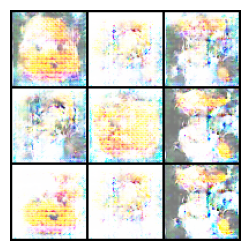

1:47
Epoch #41 / 2000, Generator Loss: 1.7187587022781372, Discriminator Loss: 0.6509500741958618
Epoch #42 / 2000, Generator Loss: 1.4195234775543213, Discriminator Loss: 0.6520087718963623
Epoch #43 / 2000, Generator Loss: 1.8777660131454468, Discriminator Loss: 0.6506799459457397
Epoch #44 / 2000, Generator Loss: 1.8322839736938477, Discriminator Loss: 0.6519370675086975
Generated images for Epoch #44:


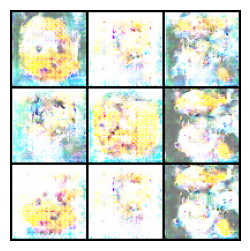

1:58
Epoch #45 / 2000, Generator Loss: 1.819237232208252, Discriminator Loss: 0.6504075527191162
Epoch #46 / 2000, Generator Loss: 1.7929625511169434, Discriminator Loss: 0.6514764428138733
Epoch #47 / 2000, Generator Loss: 1.691292643547058, Discriminator Loss: 0.650692343711853
Epoch #48 / 2000, Generator Loss: 1.672539234161377, Discriminator Loss: 0.6506714224815369
Generated images for Epoch #48:


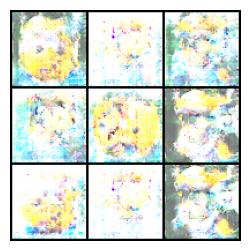

2:09
Epoch #49 / 2000, Generator Loss: 1.576284408569336, Discriminator Loss: 0.6510367393493652
Epoch #50 / 2000, Generator Loss: 1.8148690462112427, Discriminator Loss: 0.6507331728935242
Epoch #51 / 2000, Generator Loss: 1.8175432682037354, Discriminator Loss: 0.6509885787963867
Epoch #52 / 2000, Generator Loss: 1.8367486000061035, Discriminator Loss: 0.6511058807373047
Generated images for Epoch #52:


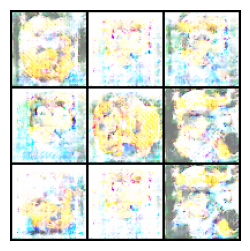

2:19
Epoch #53 / 2000, Generator Loss: 1.8168740272521973, Discriminator Loss: 0.6508912444114685
Epoch #54 / 2000, Generator Loss: 1.3943763971328735, Discriminator Loss: 0.6507056951522827
Epoch #55 / 2000, Generator Loss: 1.0087391138076782, Discriminator Loss: 0.6510013341903687
Epoch #56 / 2000, Generator Loss: 1.9308147430419922, Discriminator Loss: 0.6517025232315063
Generated images for Epoch #56:


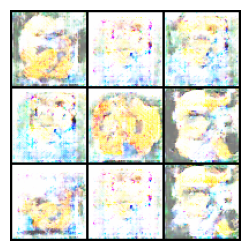

2:30
Epoch #57 / 2000, Generator Loss: 1.6908979415893555, Discriminator Loss: 0.6505883932113647
Epoch #58 / 2000, Generator Loss: 1.449934959411621, Discriminator Loss: 0.6508338451385498
Epoch #59 / 2000, Generator Loss: 1.1014996767044067, Discriminator Loss: 0.6507168412208557
Epoch #60 / 2000, Generator Loss: 1.4418200254440308, Discriminator Loss: 0.6508344411849976
Generated images for Epoch #60:


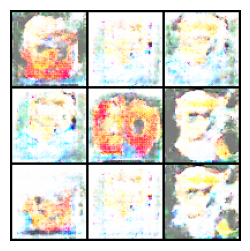

2:40
Epoch #61 / 2000, Generator Loss: 1.555709719657898, Discriminator Loss: 0.6506495475769043
Epoch #62 / 2000, Generator Loss: 1.489318609237671, Discriminator Loss: 0.6508506536483765
Epoch #63 / 2000, Generator Loss: 1.104614019393921, Discriminator Loss: 0.6507938504219055
Epoch #64 / 2000, Generator Loss: 1.110947608947754, Discriminator Loss: 0.6540870666503906
Generated images for Epoch #64:


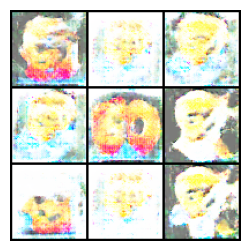

2:51
Epoch #65 / 2000, Generator Loss: 1.9119406938552856, Discriminator Loss: 0.653546929359436
Epoch #66 / 2000, Generator Loss: 1.4802374839782715, Discriminator Loss: 0.6505411863327026
Epoch #67 / 2000, Generator Loss: 1.7650456428527832, Discriminator Loss: 0.6508321762084961
Epoch #68 / 2000, Generator Loss: 1.4114758968353271, Discriminator Loss: 0.6506755352020264
Generated images for Epoch #68:


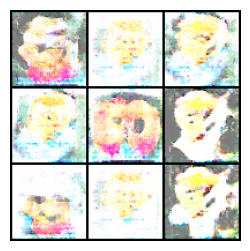

3:01
Epoch #69 / 2000, Generator Loss: 1.1300818920135498, Discriminator Loss: 0.6517393589019775
Epoch #70 / 2000, Generator Loss: 1.1932584047317505, Discriminator Loss: 0.650933563709259
Epoch #71 / 2000, Generator Loss: 0.964349091053009, Discriminator Loss: 0.6511719226837158
Epoch #72 / 2000, Generator Loss: 1.0105196237564087, Discriminator Loss: 0.6523458957672119
Generated images for Epoch #72:


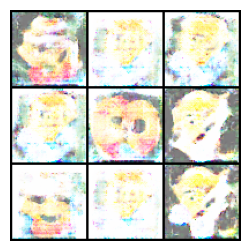

3:12
Epoch #73 / 2000, Generator Loss: 1.4474729299545288, Discriminator Loss: 0.6509679555892944
Epoch #74 / 2000, Generator Loss: 0.9799184799194336, Discriminator Loss: 0.6506192684173584
Epoch #75 / 2000, Generator Loss: 0.9384185671806335, Discriminator Loss: 0.6505588293075562
Epoch #76 / 2000, Generator Loss: 1.09197998046875, Discriminator Loss: 0.6507492661476135
Generated images for Epoch #76:


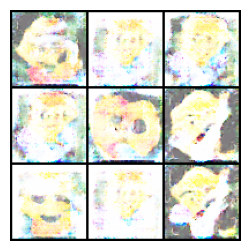

3:23
Epoch #77 / 2000, Generator Loss: 1.0590229034423828, Discriminator Loss: 0.650652289390564
Epoch #78 / 2000, Generator Loss: 1.0892258882522583, Discriminator Loss: 0.650856614112854
Epoch #79 / 2000, Generator Loss: 1.2573436498641968, Discriminator Loss: 0.6509498953819275
Epoch #80 / 2000, Generator Loss: 1.2591943740844727, Discriminator Loss: 0.6506091952323914
Generated images for Epoch #80:


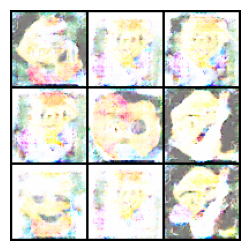

3:33
Epoch #81 / 2000, Generator Loss: 1.0995700359344482, Discriminator Loss: 0.6504281759262085
Epoch #82 / 2000, Generator Loss: 1.1824642419815063, Discriminator Loss: 0.6508433818817139
Epoch #83 / 2000, Generator Loss: 1.0157663822174072, Discriminator Loss: 0.6512078046798706
Epoch #84 / 2000, Generator Loss: 1.3649283647537231, Discriminator Loss: 0.6505672931671143
Generated images for Epoch #84:


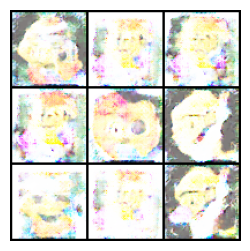

3:44
Epoch #85 / 2000, Generator Loss: 1.251335859298706, Discriminator Loss: 0.6508193612098694
Epoch #86 / 2000, Generator Loss: 1.08890700340271, Discriminator Loss: 0.6521016359329224
Epoch #87 / 2000, Generator Loss: 1.0645776987075806, Discriminator Loss: 0.6507261991500854
Epoch #88 / 2000, Generator Loss: 1.4238449335098267, Discriminator Loss: 0.6506509780883789
Generated images for Epoch #88:


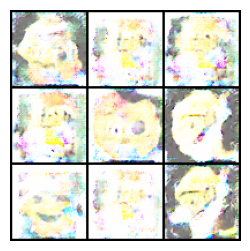

3:54
Epoch #89 / 2000, Generator Loss: 0.962611198425293, Discriminator Loss: 0.6508538722991943
Epoch #90 / 2000, Generator Loss: 1.0261385440826416, Discriminator Loss: 0.650558590888977
Epoch #91 / 2000, Generator Loss: 1.0423378944396973, Discriminator Loss: 0.6510437726974487
Epoch #92 / 2000, Generator Loss: 0.9864077568054199, Discriminator Loss: 0.6505622267723083
Generated images for Epoch #92:


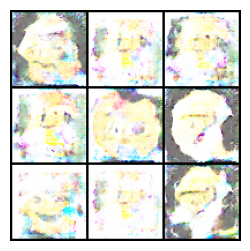

4:05
Epoch #93 / 2000, Generator Loss: 1.0796051025390625, Discriminator Loss: 0.6504840850830078
Epoch #94 / 2000, Generator Loss: 1.1236565113067627, Discriminator Loss: 0.6520713567733765
Epoch #95 / 2000, Generator Loss: 0.9050875902175903, Discriminator Loss: 0.6651822328567505
Epoch #96 / 2000, Generator Loss: 1.8749947547912598, Discriminator Loss: 0.6509929895401001
Generated images for Epoch #96:


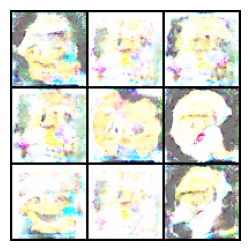

4:16
Epoch #97 / 2000, Generator Loss: 1.759342908859253, Discriminator Loss: 0.6506145000457764
Epoch #98 / 2000, Generator Loss: 1.7298284769058228, Discriminator Loss: 0.6505940556526184
Epoch #99 / 2000, Generator Loss: 1.7149369716644287, Discriminator Loss: 0.6507710218429565
Epoch #100 / 2000, Generator Loss: 1.612824559211731, Discriminator Loss: 0.6508183479309082
Generated images for Epoch #100:


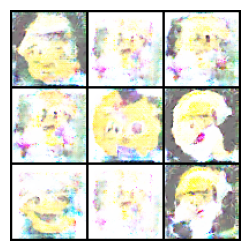

4:26
Epoch #101 / 2000, Generator Loss: 1.496485710144043, Discriminator Loss: 0.6505833864212036
Epoch #102 / 2000, Generator Loss: 1.4283945560455322, Discriminator Loss: 0.6515955328941345
Epoch #103 / 2000, Generator Loss: 1.2133761644363403, Discriminator Loss: 0.650702714920044
Epoch #104 / 2000, Generator Loss: 1.239484190940857, Discriminator Loss: 0.650617241859436
Generated images for Epoch #104:


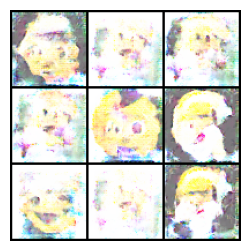

4:37
Epoch #105 / 2000, Generator Loss: 1.1326086521148682, Discriminator Loss: 0.6507507562637329
Epoch #106 / 2000, Generator Loss: 1.1100752353668213, Discriminator Loss: 0.6508076190948486
Epoch #107 / 2000, Generator Loss: 1.0650169849395752, Discriminator Loss: 0.6508786678314209
Epoch #108 / 2000, Generator Loss: 0.983473539352417, Discriminator Loss: 0.650708794593811
Generated images for Epoch #108:


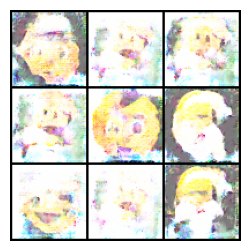

4:47
Epoch #109 / 2000, Generator Loss: 1.0763884782791138, Discriminator Loss: 0.6504839658737183
Epoch #110 / 2000, Generator Loss: 0.9944984912872314, Discriminator Loss: 0.6505099534988403


KeyboardInterrupt: 

In [15]:
#use binary cross entropy for loss
loss_function = nn.BCELoss()

#for best results use: num_epochs = really big number
num_epochs = 2000

batch_size = 256
d_losses, g_losses = [], []

#define dataloaders
dataset = TensorDataset(images, labels)

# We need a random number generator that works on gpu for shuffle to work
random_generator = torch.Generator(device=torch.get_default_device())
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=random_generator)

#learning rate and optimizers
learning_rate = 0.0002
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)

start_time = time.time()


# How frequently to show and save sample images
image_epoch_frequency = 4
# How often to save the model weights
model_save_frequency = 10
# How many times to train the discriminator for 1 pass on the generator
discriminator_passes = 3
# Discriminator training noise amount
training_noise = 0.04

#training loop for generating emojis
for epoch in range(num_epochs):
    #dataloader shuffles the batches

    for d_pass in range(discriminator_passes):
        for real_data, iteration in dataloader:
            #only need this line if running on cuda:
            real_data = real_data.to(processing_device)

            if training_noise > 0:
                real_data += torch.randn(real_data.shape) * training_noise

            #train the discriminator
            d_optimizer.zero_grad()
            real_pred = discriminator(real_data)
            real_loss = loss_function(real_pred, real_targets(real_data.size(0)))
            
            fake_data = generator(noise(real_data.size(0))).detach()

            if training_noise > 0:
                fake_data += torch.randn(fake_data.shape) * training_noise
            
            fake_pred = discriminator(fake_data)
            fake_loss = loss_function(fake_pred, fake_targets(fake_data.size(0)))
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()

    for real_data, iteration in dataloader:
        #train the generator
        g_optimizer.zero_grad()
        fake_data = generator(noise(batch_size))
        fake_pred = discriminator(fake_data)
        g_loss = loss_function(fake_pred, real_targets(batch_size))
        g_loss.backward()
        g_optimizer.step()

    #record losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    print(f"Epoch #{epoch} / {num_epochs}, Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}")


    #print images at every x epochs
    if epoch % image_epoch_frequency == 0:
        print(f"Generated images for Epoch #{epoch}:")
        input_noise = noise(9) if sample_noise == None else sample_noise
        image_grid(3, 3, input_noise=sample_noise, size=3, save_path=f'progress4/{epoch}.jpg')

        now = int(time.time() - start_time)
        print(f'{now // 60}:{now % 60:02}')

    if epoch % model_save_frequency == 0:
        save_model()
    

#generate final set of images
image_grid(4, 4)

In [50]:
def best_emoji_output(generator, discriminator, generated_images):
    #if cuda is used, then the images must be on the same device (GPU using cuda)
    #generated_images = generated_images.to(processing_device)

    #target yellow color using RGB
    #if using cude make sure to use param for device: target_yellow = torch.tensor([1.0, 1.0, 0.0], device=processing_device).view(1, 3, 1, 1)
    target_yellow = torch.tensor([1.0, 1.0, 0.0]).view(1, 3, 1, 1)  #looks for a brighter yellow

    #selecting the best yellow emoji
    def select_best_yellow_emoji(generated_images, discriminator):
        scores = []
        for img in generated_images:
            #only needed for cuda usage:
            #img = img.to(processing_device)

            #gets discriminator scores
            disc_score = discriminator(img.unsqueeze(0)).item()

            #computes the color similarity to yellow
            avg_color = img.mean(dim=(1, 2))  #average color per channel
            yellow_bias = -F_nn.mse_loss(avg_color, target_yellow.view(-1))  #the lower the MSE the closer the color is to yellow

            combined_score = disc_score + yellow_bias.item()
            scores.append(combined_score)

        #gets the image with highest score
        best_index = scores.index(max(scores))
        best_image = generated_images[best_index]
        print(f"The best generated emoji had a score of: {scores[best_index]}")
        return best_image

    best_emoji = select_best_yellow_emoji(generated_images, discriminator)

    #output the best emoji
    print(f"Here is the best chosen, final generated emoji:")
    plt.figure(figsize=(4, 4))
    grid = torchvision.utils.make_grid(best_emoji.unsqueeze(0), normalize=True)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.show()

best_emoji_output(generator, discriminator, generated_images)

NameError: name 'generated_images' is not defined

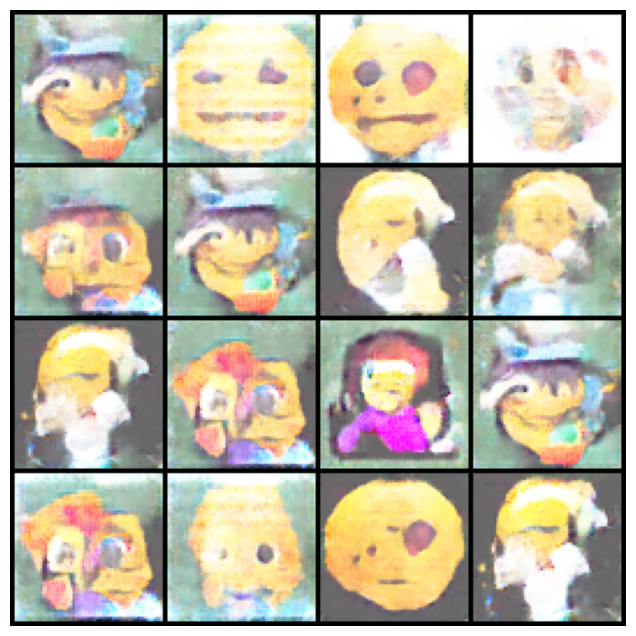

In [19]:
image_grid(4, 4)

In [25]:
# This exports the model in the ONNX format so it can be used on a website.
# You need onnx installed: 'pip install onnx'
torch.onnx.export(generator, (noise(1),), 'model.onnx', input_names=['input'], output_names=['output'])

tensor([[ 0.0452,  0.9785,  0.5412, -1.5842,  0.3201, -1.2122, -0.1121, -0.3994,
         -0.1090,  0.9974, -0.5831,  1.2389, -0.7540, -0.0452, -0.6943, -0.4557,
          0.0488, -0.5095,  0.0950, -0.5702,  1.2090, -2.0802, -0.4485,  0.2961,
         -0.1948, -1.4766,  0.6726,  0.1664, -0.1813,  0.1456, -0.7986, -1.7796,
         -0.2345,  1.1202,  1.7319, -0.5127, -0.2837,  0.6130, -1.5276, -0.5256,
         -0.4143, -0.5227, -0.4901, -0.4791,  0.6040,  0.2983, -1.5111,  1.3629,
         -0.2271, -1.5814, -1.9099, -0.9880, -0.3647, -0.5544,  0.1261,  2.0953,
          0.8690, -0.2131,  1.7900,  0.1229, -1.0457,  1.0736,  0.9359, -0.1364,
         -0.2982,  0.4300,  0.5376,  0.6805,  1.3576,  0.7296, -0.1719,  0.8455,
         -0.3712,  0.0705, -0.9302,  1.0567,  0.1960,  2.1608,  0.2013, -0.8483,
         -0.3340,  2.4853, -1.0367, -0.8782, -0.5115,  0.7011, -0.1841,  0.4415,
         -1.3967, -0.6406,  0.8192,  0.0142, -0.4338,  0.3134,  0.0681,  0.1441,
          0.5165,  0.5266,  

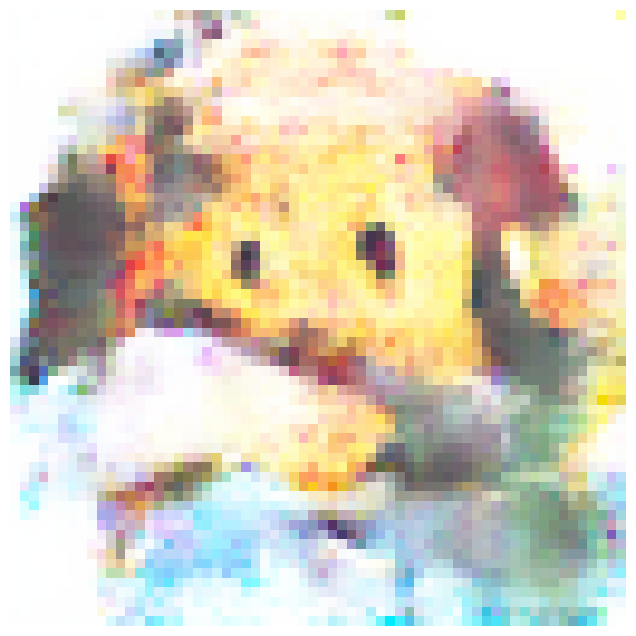

In [23]:
n = noise(1)
print(n)
image_grid(1, 1, input_noise=n)

In [26]:
print(generator(n))

tensor([[[[0.9999, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9996],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 0.9988,  ..., 0.8706, 0.9331, 0.9077],
          [0.9999, 1.0000, 0.9999,  ..., 0.4120, 0.9679, 0.9849],
          [0.9994, 0.9998, 0.9994,  ..., 0.6091, 0.9778, 0.9901]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.9675, 0.9802, 0.9682],
          [1.0000, 1.0000, 1.0000,  ..., 0.9636, 0.9934, 0.9973],
          [1.0000, 1.0000, 0.9999,  ..., 0.9584, 0.9969, 0.9962]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.5009],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1